In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from modules import *
from sim import *


In [3]:
#sim_eps0p01 = Sim(ALPHA_EPS0P01, "gridded_data_small.npz", epsilon_SF=0.01)
#sim_eps0p1 = Sim(ALPHA_EPS0P1, "gridded_data_small.npz", epsilon_SF=0.1)
#sim_eps1p0 = Sim(ALPHA_EPS1P0, "gridded_data_small.npz", epsilon_SF=1.0)
#sim_gas = Sim(GAS, "gridded_data_small.npz", epsilon_SF=None)
#list_of_sim = [sim_eps0p01, sim_eps0p1, sim_eps1p0, sim_gas]
#sim = sim_gas


In [4]:
sim = Sim(0, "alpha_eps0p1", "gridded_data_small.npz", epsilon_SF=None)
#sim2 = Sim(1, "alpha_eps0p1_highres", "data_d12_l4_b2.npz", epsilon_SF=None)


Moving to directory '/home/za9132/scratch/romain/round0/alpha_eps0p1'.


### Accretion

In [7]:
h = np.cross(sim.coord, sim.vel_vec, axis=0)
h_tot = sim.calc_mean(h, weight=(sim.density * sim.dV), axis=(1, 2, 3), do_sum=True)
h_scalar = proj(h, h_tot[:, None, None, None])

Ldot = sim.interp_to_sph(h_scalar * sim.density * sim.vel_vec_sph_at_cart[R]) * sim.dA_hph
Ldot1d = sim.calc_mean(Ldot, axis=(1, 2), do_sum=True)


Text(0, 0, '$z$')

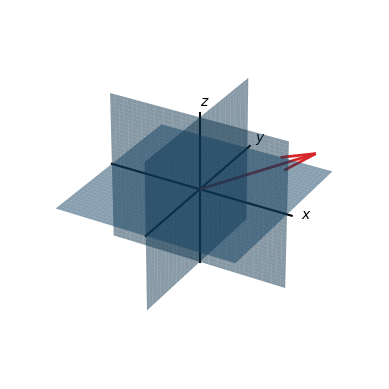

In [10]:
ax = plt.figure().add_subplot(projection='3d')

x, y = np.mgrid[-1:1:0.05, -1:1:0.05]
z = np.zeros_like(x)

ax.plot_surface(x, y, z, color='C0', alpha=0.5)
ax.plot_surface(z, y, x, color='C0', alpha=0.5)
ax.plot_surface(x, z, y, color='C0', alpha=0.5)

ax.quiver(0, 0, 0, h_tot[X], h_tot[Y], h_tot[Z], length=1.2, normalize=True, lw=2, color='C3')

ax.plot([-1, 1], [0, 0], [0, 0], color='black')
ax.plot([0, 0], [-1, 1], [0, 0], color='black')
ax.plot([0, 0], [0, 0], [-1, 1], color='black')

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")

ax.axis("off")

ax.text(1.1, 0, 0, r"$x$")
ax.text(0, 1.1, 0, r"$y$")
ax.text(0, 0, 1.1, r"$z$")

# sim.save_fig("L-axis")


Text(0.5, 1.0, '$L_0$ is the angular momentum of $M_\\odot$ in a circular Keplerian orbit at $r = 1~{\\rm kpc}$')

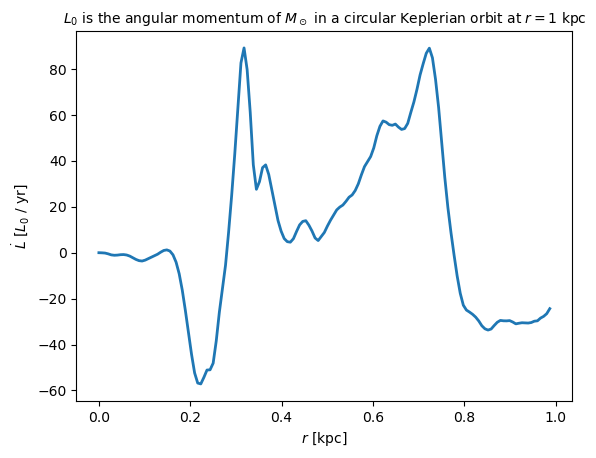

In [11]:
radius = 1 * const.kpc
M_enc = sim.calc_mean(sim.density * sim.dV, cond=(sim.coord_sph[R] < radius), do_sum=True)
L0 = const.M_sol * np.sqrt(const.G * M_enc * radius)

plt.plot(sim.coord1d_sph[R] / const.kpc, Ldot1d / (L0 / const.yr), lw=2)

plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$\dot{L}$ [$L_0~/~{\rm yr}$]")

plt.title(r"$L_0$ is the angular momentum of $M_\odot$ in a circular Keplerian orbit at $r = %.3g~{\rm kpc}$" % (radius / const.kpc), fontsize=10)

# sim.save_fig("Ldot")


In [203]:
Mdot = -sim.vel_vec_sph_at_cart[R] * sim.density * sim.dA_hph
Mdot_sph = sim.interp_to_sph(Mdot)
Mdot1d = sim.calc_mean(Mdot, axis=(H, PH), do_sum=True)
density_sph = sim.interp_to_sph(sim.density)


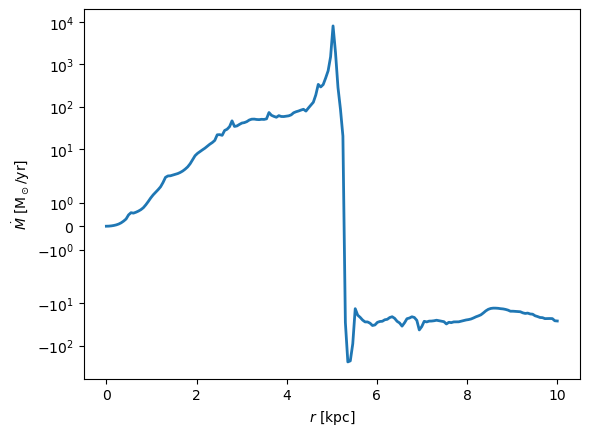

In [205]:
plt.plot(sim.coord1d_sph[R] / const.kpc, Mdot1d / (const.M_sol / const.yr), lw=2)

plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$\dot{M}$ [${\rm M_\odot/yr}$]")

plt.yscale('symlog')

# sim.save_fig("Mdot")


In [ ]:
kwargs = {
    "field": Arglist([["density_dm", "density_star", "density"]]),
    "unit": const.M_sol / const.kpc**2,
    "extrema": (1e5, 1e11),
    "avg": False,
    "project": True,
    "slice": slice,
    "do_log": True,
    "cmap": Arglist([['cividis', 'afmhot', 'inferno']]),
    "cbar_tick_increment": 0.,
    "cbar_label": "$\dot{M}$ [${\rm M_\odot / yr}$]",
    "cbar_orientation": "horizontal"
}

sim.plot_grid(**kwargs, nrows=1, ncols=3, figsize=(12, 5), wspace=1e-3, hspace=None, sharey=True, ptype='AH')


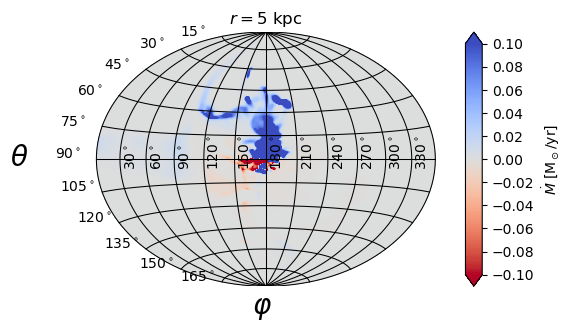

In [212]:
radius = 5. * const.kpc
radius_idx = np.argmin(np.abs(sim.coord1d_sph[R] - radius))

sim.plot(Mdot[radius_idx], unit=(const.M_sol / const.yr), extrema=(-1e-1, 1e-1), ptype='AH', do_log=False, cmap='coolwarm_r', num_axis_lines=12, cbar_tick_increment=0.02, cbar_label=r'$\dot{M}$ [${\rm M_\odot/yr}$]', title=r"$r = %.3g~{\rm kpc}$" % (radius / const.kpc))

# sim.save_fig("Mdot-sph")


Text(0.5, 1.0, '$r \\in [4.5, 5]~{\\rm kpc}$')

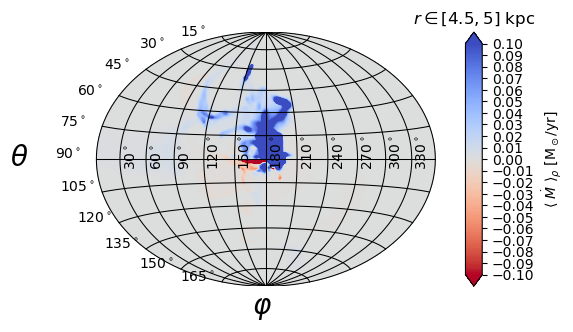

In [217]:
radius_in, radius_out = 4.5 * const.kpc, 5. * const.kpc
cond = (sim.coord_sph[R] < radius_out) * (sim.coord_sph[R] > radius_in)

Mdot_avg = sim.calc_mean(Mdot, weight=(density_sph * sim.dx_sph[R]), cond=cond, axis=R)

sim.plot(Mdot_avg, unit=(const.M_sol / const.yr), extrema=(-0.1, 0.1), ptype='AH', do_log=False, cmap='coolwarm_r', num_axis_lines=12, cbar_tick_increment=0.01, cbar_label=r'$\langle~\dot{M}~\rangle_\rho$ [${\rm M_\odot/yr}$]')

plt.title(r"$r \in [%.3g, %.3g]~{\rm kpc}$" % (radius_in / const.kpc, radius_out / const.kpc))

# sim.save_fig("Mdot-sph-avg")


### Dust

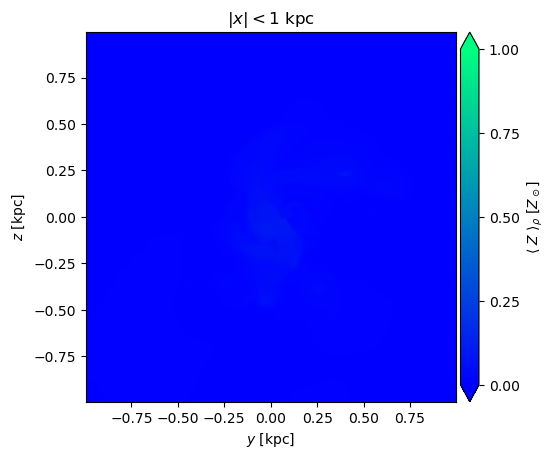

In [135]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot(sim.metallicity / const.Z_sol, (0, 1), avg=True, slice=slice, weight=sim.density, project=True, do_log=False, cmap='winter', cbar_label=r'$\langle~Z~\rangle_\rho$ [$Z_\odot$]', cbar_tick_increment=0.25, title=r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("metal-proj-%s" % slice_label)


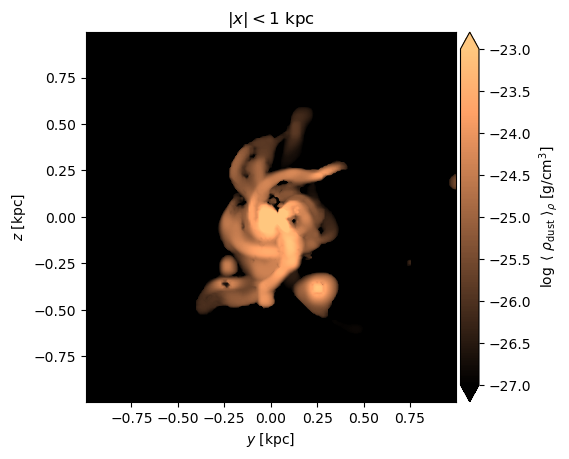

In [136]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot(sim.density_dust, (1e-27, 1e-23), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='copper', cbar_label=r'$\log~\langle~\rho_{\rm dust}~\rangle_\rho$ [${\rm g/cm^{3}}$]', cbar_tick_increment=0.5, title=r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("dust-proj-%s" % slice_label)


In [43]:
n_H_sph = sim.interp_to_sph(sim.n_H)
N_H = np.sum(n_H_sph * sim.dx_sph[R], axis=R)


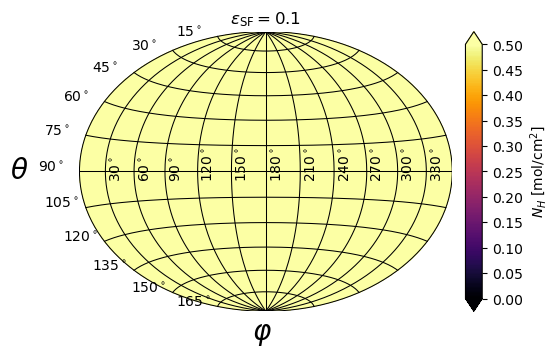

In [44]:
sim.plot(N_H, (0, 0.5), unit=const.N_A, do_log=False, cmap='inferno', num_axis_lines=12, cbar_tick_increment=0.05, cbar_label=r'$N_H$ [${\rm mol/cm^{2}}$]', title=sim.sim_latex, ptype='AH') 

# sim.save_fig("dust-sph")


In [45]:
density_sph = sim.interp_to_sph(sim.density)
col_density = np.sum(density_sph * sim.dx_sph[R], axis=R)


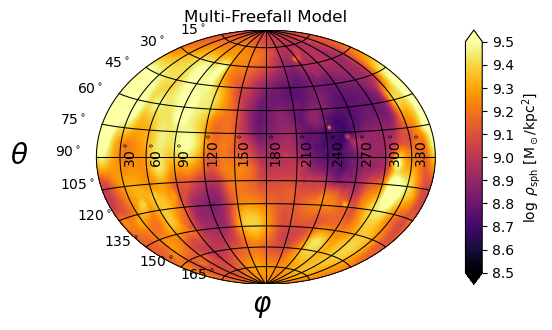

In [108]:
sim.plot(col_density, (10**(8.5), 10**(9.5)), unit=(const.M_sol/const.kpc**2), do_log=True, cmap='inferno', num_axis_lines=12, cbar_tick_increment=0.1, cbar_label=r'$\log~\rho_{\rm sph}$ [${\rm M_\odot/kpc^2}$]', title=sim.sim_latex, ptype='AH') 

# sim.save_fig("dust-sph")


In [109]:
density_dust_sph = sim.interp_to_sph(sim.density_dust)
col_density_dust = np.sum(density_dust_sph * sim.dx_sph[R], axis=R)


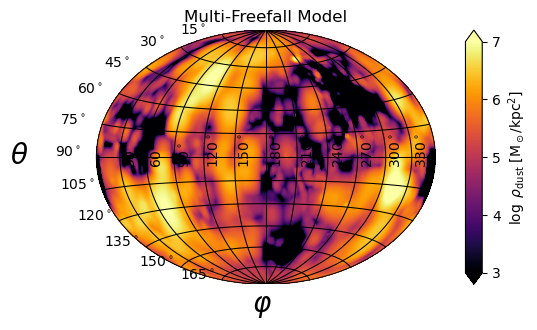

In [112]:
sim.plot(col_density_dust, (1e3, 1e7), ptype='AH', unit=(const.M_sol/const.kpc**2), do_log=True, cmap='inferno', num_axis_lines=12, cbar_tick_increment=1, cbar_label=r'$\log~\rho_{\rm dust}$ [${\rm M_\odot/kpc^2}$]', title=sim.sim_latex) 
    
# sim.save_fig("dust-sph")


### Multi-freefall Model

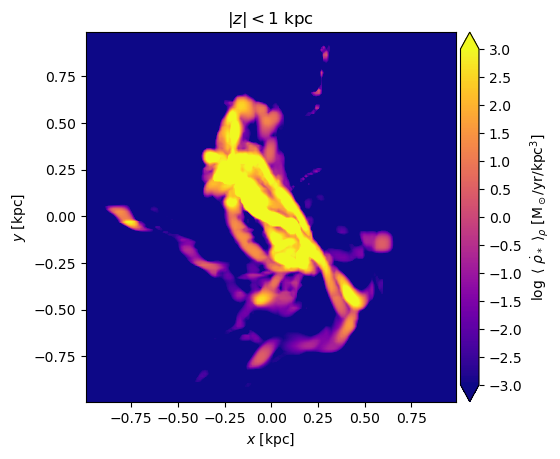

In [9]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot(sim.SFR_density / (const.M_sol / const.yr / const.kpc**3), (1e-3, 1e3), title=r'$|%s| < 1~{\rm kpc}$' % slice_label, avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='plasma', cbar_label=r'$\log~\langle~\dot{\rho}_*~\rangle_\rho$ [${\rm M_\odot/yr/kpc^3}$]', cbar_tick_increment=0.5)

# sim.save_fig("SFR-proj-%s" % slice_label)


### Gas Properties

Text(0.5, 1.0, '$|z| < 1~{\\rm kpc}$')

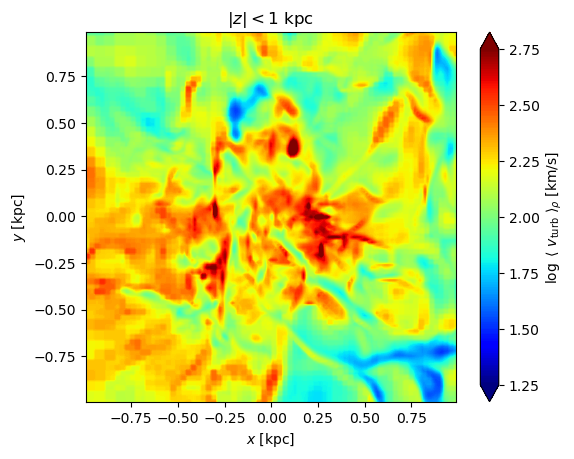

In [5]:
slice = Z
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.vel_turb / (const.km), (10**(1.25), 10**(2.75)), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='jet', cbar_label=r'$\log~\langle~v_{\rm turb}~\rangle_\rho$ [km/s]', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("v-proj-%s" % slice_label)


Text(0.5, 1.0, '$|x| < 1~{\\rm kpc}$')

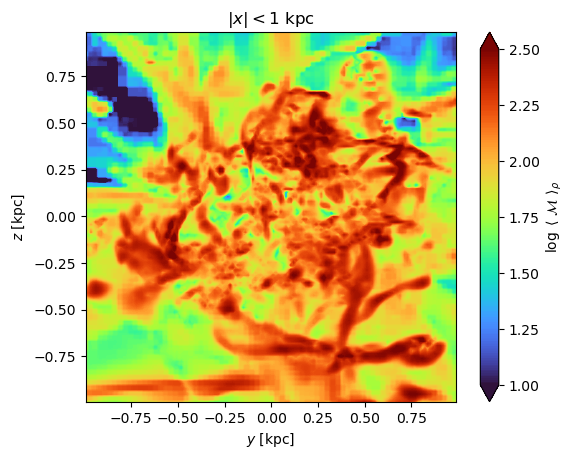

In [6]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot_slice(sim.mach, (10**(1.), 10**(2.5)), avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='turbo', cbar_label=r'$\log~\langle~\mathcal{M}~\rangle_\rho$', cbar_tick_increment=0.25)

plt.title(r'$|%s| < 1~{\rm kpc}$' % slice_label)

# sim.save_fig("mach-proj-%s" % slice_label)


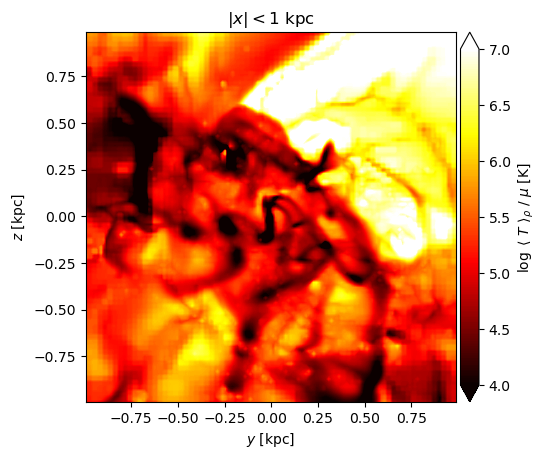

In [5]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot(sim.temp, (1e4, 1e7), title=r'$|%s| < 1~{\rm kpc}$' % slice_label, avg=True, slice=slice, weight=sim.density, project=True, do_log=True, cmap='hot', cbar_label=r'$\log~\langle~T~\rangle_\rho~/~\mu$ [K]', cbar_tick_increment=0.5)

# sim.save_fig("temp-proj-%s" % slice_label)


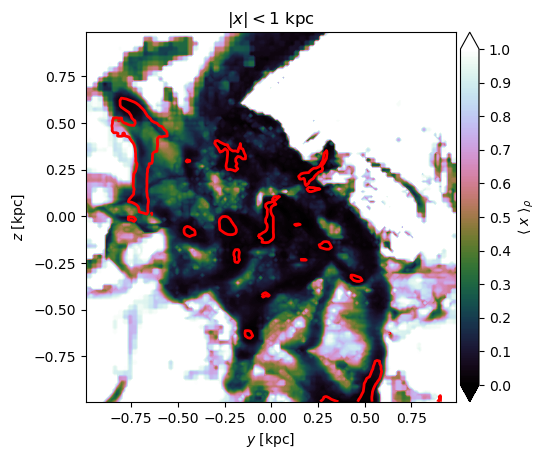

In [7]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot(sim.ion_frac, (0, 1), avg=True, slice=slice, title=r'$|%s| < 1~{\rm kpc}$' % slice_label, weight=sim.density, project=True, do_log=False, cmap='cubehelix', cbar_label=r'$\langle~x~\rangle_\rho$', cbar_tick_increment=0.1, isocontours=[const.temp_HII], isocontour_field=sim.temp, color_isocontour='red')

# sim.save_fig("temp-proj-%s" % slice_label)


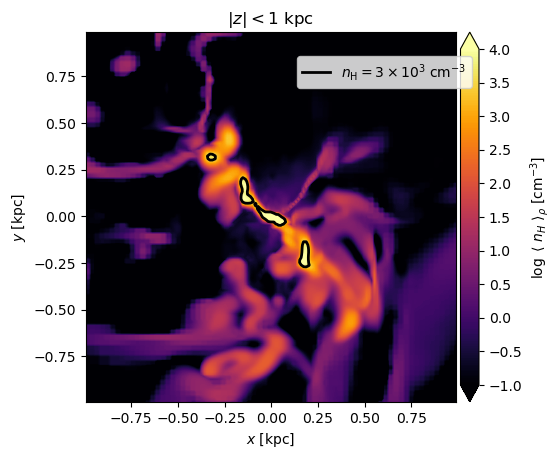

In [10]:
slice = Z
slice_label = ["x", "y", "z"][slice]

n_H_crit_ffb = 3e3
cond_ffb = sim.n_H < n_H_crit_ffb

sim.plot("n_H", (1e-1, 1e4), title=r'$|%s| < 1~{\rm kpc}$' % slice_label, avg=True, slice=slice, weight="density", project=False, do_log=True, cmap='inferno', cbar_label=r'$\log~\langle~n_H~\rangle_\rho$ [${\rm cm^{-3}}$]', cbar_tick_increment=0.5, isocontours=[n_H_crit_ffb])

custom_lines = [Line2D([0], [0], color='black', lw=2)]
plt.legend(custom_lines, [r'$n_{\rm H} = 3\times 10^{3}~{\rm cm^{-3}}$'])

# sim.save_fig("density-proj-%s" % slice_label)


In [11]:
n_H_2d, temperature_2d, mass_2d = sim.calc_phase(sim.n_H, sim.temp, (1e-4, 1e5), (1e1, 1e9), nbins=200)


Text(0.5, 1.0, '$|x|, |y|, |z| < 1~{\\rm kpc}$')

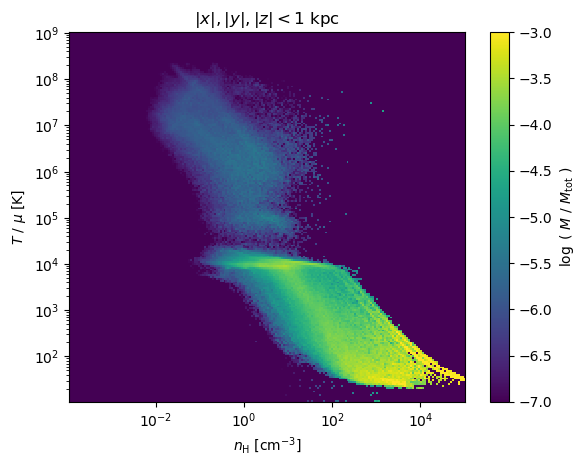

In [13]:
mass_frac_2d = mass_2d / np.sum(sim.density * sim.dV)

plt.pcolormesh(n_H_2d, temperature_2d, np.log10(mass_frac_2d + epsilon), vmin=-7, vmax=-3)

plt.xlabel(r"$n_{\rm H}$ [${\rm cm^{-3}}$]")
plt.ylabel(r"$T~/~\mu$ [K]")

plt.xscale('log')
plt.yscale('log')

plt.colorbar(label=r'$\log~(~M~/~M_{\rm tot}~)$')

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')

# sim.save_fig("density-temp-phase")


In [46]:
r1d, density1d = sim.calc_radial_profile(sim.density, nbins=50)


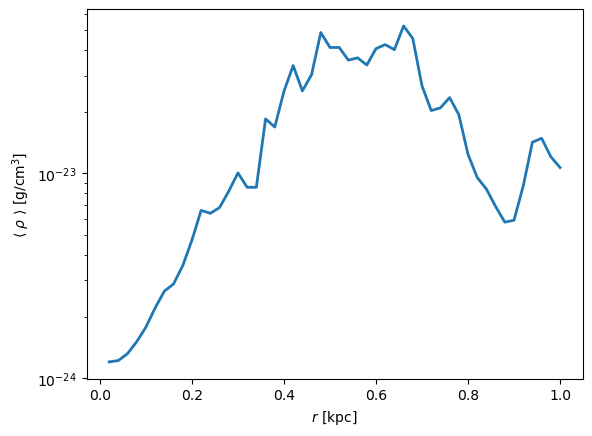

In [47]:
plt.plot(r1d / const.kpc, density1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.yscale('log')

# sim.save_fig("density-1d")


In [48]:
r1d, temp1d = sim.calc_radial_profile(sim.temp, weight=sim.density, nbins=100)


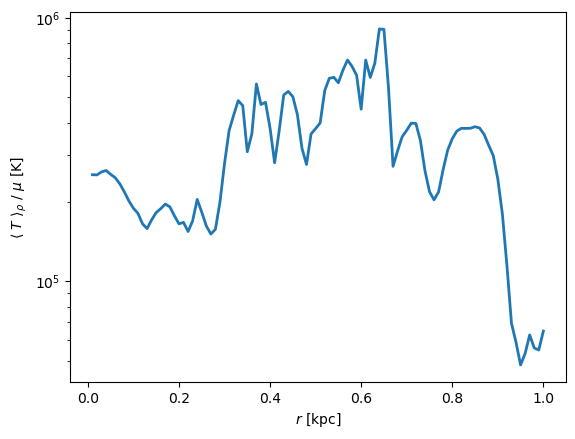

In [49]:
plt.plot(r1d / const.kpc, temp1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho~/~\mu$ [K]')

plt.yscale('log')

# sim.save_fig("temp-1d")


In [50]:
r1d, energy_turb1d = sim.calc_radial_profile(sim.energy_turb, weight=sim.density, nbins=100)
vel_turb1d = np.sqrt(2 * energy_turb1d)


Text(0, 0.5, '$\\langle~v_{\\rm turb}~\\rangle_\\rho$ [km/s]')

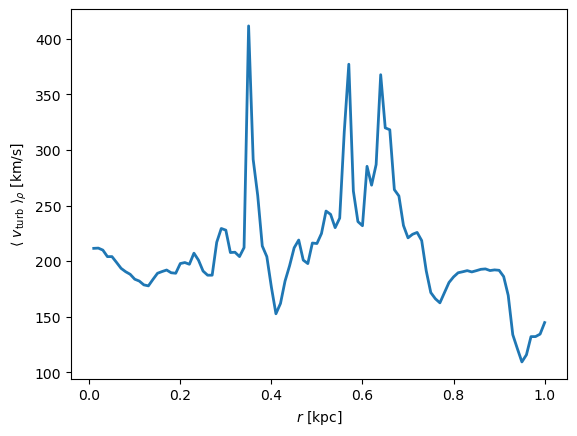

In [51]:
plt.plot(r1d / const.kpc, vel_turb1d / (const.km), lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~v_{\rm turb}~\rangle_\rho$ [km/s]')

# sim.save_fig("v-turb-1d")


### Refinement

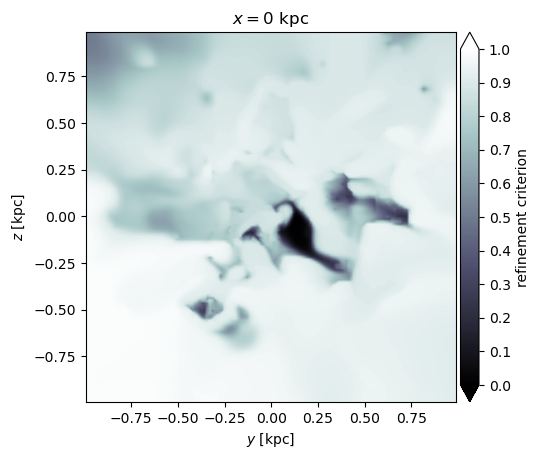

In [53]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot(sim.ref_crit, (0., 1.), slice=slice, title=r'$%s = 0~{\rm kpc}$' % slice_label, project=False, do_log=False, cmap='bone', cbar_label='refinement criterion', cbar_tick_increment=0.1)

# sim.save_fig("refine-proj-%s" % slice_label)


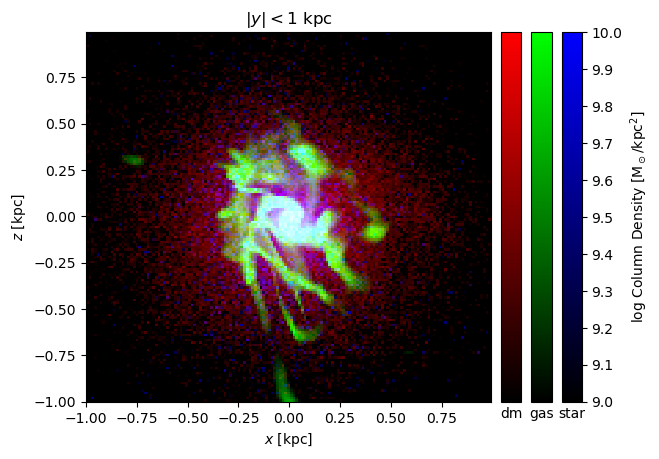

In [47]:
slice = Y
slice_label = ["x", "y", "z"][slice]

sim.plot("density_dm", "density", "density_star", (1e9, 1e10), unit=const.M_sol/const.kpc**2, xlabels=["dm", "gas", "star"], plot_type='rgb_slice', slice=slice, title=r'$|%s| < 1~{\rm kpc}$' % slice_label, project=True, do_log=True, avg=False, cbar_label=r'log Column Density [${\rm M_\odot / kpc^2}$]', cbar_tick_increment=0.1)

# sim.save_fig("refine-proj-%s" % slice_label)



Text(0.5, 1.02, '$\\varepsilon_{\\rm SF} = 0.1$\n$|x| < 10~{\\rm kpc}$')

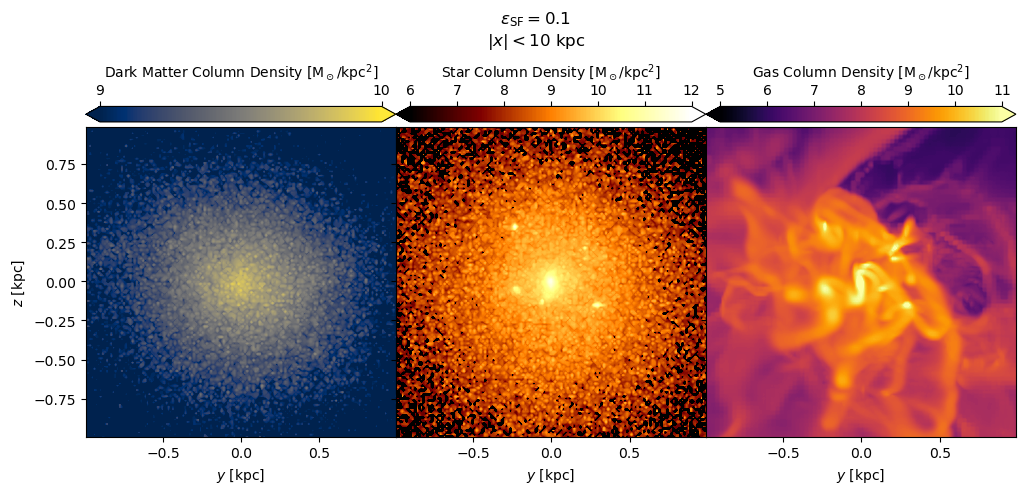

In [49]:
slice = X
slice_label = ["x", "y", "z"][slice]

kwargs = {
    "field": Arglist([["density_dm", "density_star", "density"]]),
    "unit": const.M_sol / const.kpc**2,
    "extrema": Arglist([[(1e9, 1e10), (1e6, 1e12), (1e5, 1e11)]]),
    "avg": False,
    "project": True,
    "slice": slice,
    "do_log": True,
    "cmap": Arglist([['cividis', 'afmhot', 'inferno']]),
    "cbar_tick_increment": 1.,
    "cbar_label": Arglist([[
        r'Dark Matter Column Density [${\rm M_\odot / kpc^2}$]',
        r'Star Column Density [${\rm M_\odot / kpc^2}$]',
        r'Gas Column Density [${\rm M_\odot / kpc^2}$]'
    ]]),
    "cbar_orientation": "horizontal",
    "max_pixels": 256
}

sim.plot_grid(**kwargs, nrows=1, ncols=3, figsize=(12, 5), wspace=1e-3, hspace=None, sharey=True)

plt.suptitle(sim.sim_latex + "\n" + r'$|%s| < 10~{\rm kpc}$' % slice_label, y=1.02)

# sim.save_fig("all-density-medium")


### Turbulence forcing

In [20]:
def calc_b1(vel_vec):
    ''' Compute the turbulence forcing parameter by approximating the volume integral. '''
    vel_vec_face = sim.on_face(vel_vec) # interpolate the velocity to cell faces
    vel_vec_l = np.zeros((3, sim.N, sim.N, sim.N))
    for i in [X, Y, Z]:
        vel_vec_l[i] = 3 * (vel_vec_face[i][i].take(np.arange(sim.N)+1, axis=i) - vel_vec_face[i][i].take(np.arange(sim.N), axis=i))
        for j in [X, Y, Z]:
            vel_vec_l[i] += -(vel_vec_face[j][i].take(np.arange(sim.N)+1, axis=j) + vel_vec_face[j][i].take(np.arange(sim.N), axis=j))
    vel_vec_l /= 3*np.pi 
    vel_l = norm(vel_vec_l)
    b = np.sqrt(3) * vel_l**2 / sim.vel**2
    # enforce maximum and minimum values of b
    b[b >= 1] = 1.
    b[b <= 1/3] = 1/3
    return b

def calc_b2(vel_vec):
    ''' Compute the turbulence forcing parameter by heuristically combining the divergence and curl of the velocity. '''
    vel_div = sim.div(sim.vel_vec)
    vel_curl = sim.curl(sim.vel_vec)
    E_div = norm(vel_div)**2
    E_curl = norm(vel_curl)**2
    zeta = E_div / (E_div + E_curl)
    b = 1/3 + 2/3 * zeta**3
    return b
        

Saved figure as 'turb-forcing-x-102720230936.png'


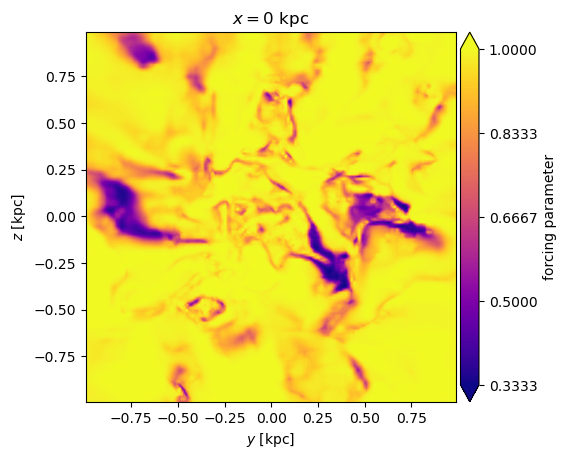

In [30]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot(calc_b2(sim.vel_vec), (1/3., 1.), slice=slice, project=False, avg=True, weight=sim.density, do_log=False, cmap='plasma', cbar_label='forcing parameter', cbar_tick_increment=1/6, title=r'$%s = 0~{\rm kpc}$' % slice_label)

sim.save_fig("turb-forcing-%s" % slice_label)



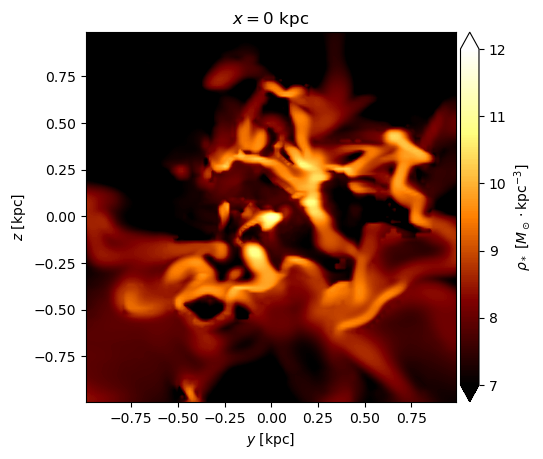

In [65]:
slice = X
slice_label = ["x", "y", "z"][slice]

sim.plot(sim.density, (1e7, 1e12), slice=slice, unit=const.M_sol / const.kpc**3, project=False, avg=True, weight=sim.density, do_log=True, cmap='afmhot', cbar_label=r'$\rho_*$ [$M_\odot \cdot {\rm kpc}^{-3}$]', cbar_tick_increment=1, title=r'$%s = 0~{\rm kpc}$' % slice_label)

# sim.save_fig("refine-proj-%s" % slice_label)


### Star Formation Rate

Text(0.5, 1.0, '$|x|, |y|, |z| < 1~{\\rm kpc}$')

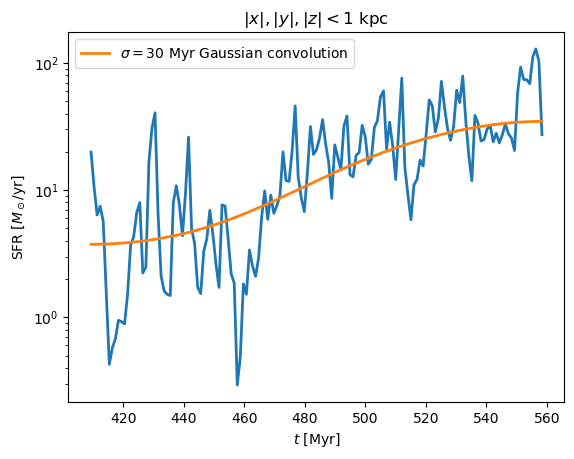

In [28]:
nbins = 150
filter_sigma = 30 * const.Myr
time_range = 150 * const.Myr

counts, bins = np.histogram(sim.time_starbirth, bins=np.linspace(sim.time_now - time_range, sim.time_now, nbins), weights=sim.mass_star)

time_starbirth = bins[:-1] + np.diff(bins)[0]
mass_star = counts
SFR_mass = mass_star / np.diff(bins)[0]

filter_sigma_idx = filter_sigma / np.diff(time_starbirth)[0]
SFR_mass_smoothed = 10**gaussian_filter(np.log10(SFR_mass + epsilon), sigma=filter_sigma_idx)

plt.plot(time_starbirth / const.Myr, SFR_mass / const.M_sol * const.yr, lw=2, color='C0')
plt.plot(time_starbirth / const.Myr, SFR_mass_smoothed / const.M_sol * const.yr, lw=2, color='C1', label=r'$\sigma = %.3g~{\rm Myr}$ Gaussian convolution' % (filter_sigma / const.Myr))

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

plt.yscale('log')

plt.legend()

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')

# sim.save_fig("SFR")


Text(0.5, 1.0, '$\\sigma = 30~{\\rm Myr}$ Gaussian convolution')

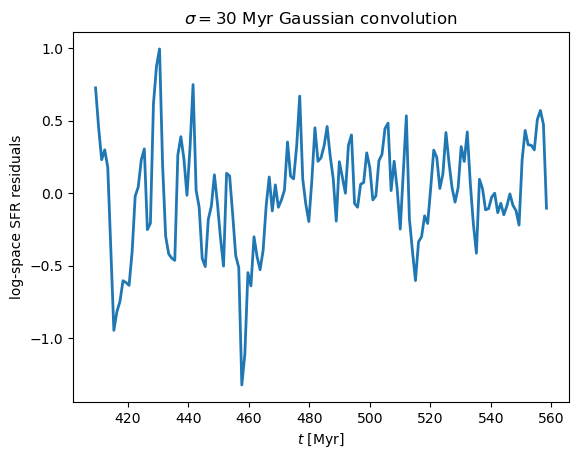

In [31]:
log_SFR_res = np.log10(SFR_mass) - np.log10(SFR_mass_smoothed)

plt.plot(time_starbirth / const.Myr, log_SFR_res, lw=2)

plt.ylabel(r"log-space SFR residuals")
plt.xlabel(r"$t$ [Myr]")

plt.title(r'$\sigma = %.3g~{\rm Myr}$ Gaussian convolution' % (filter_sigma / const.Myr))

# sim.save_fig("SFR-res")


In [48]:
calc_ion_frac(1e4, 1e-21)


1.0

Text(0, 0.5, 'PSD [Myr]')

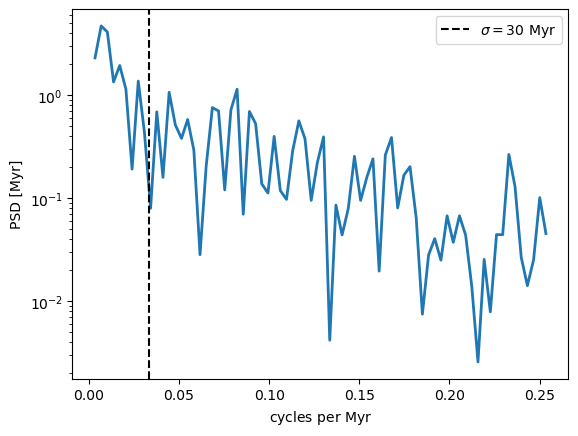

In [34]:
freq_starbirth, log_SFR_res_PSD = welch(log_SFR_res, fs=1/np.diff(star_birth_time)[0], detrend=None, scaling='density', nperseg=256)

plt.plot((freq_starbirth[1:] * const.Myr)**(1), log_SFR_res_PSD[1:] / const.Myr, lw=2)

plt.yscale('log')

plt.axvline(x=(filter_sigma**(-1) * const.Myr), color='black', linestyle='--', label=r'$\sigma = %.3g~{\rm Myr}$' % (filter_sigma / const.Myr))

plt.legend()

plt.xlabel(r"${\rm cycles\ per\ Myr}$")
plt.ylabel(r"PSD [Myr]")

# sim.save_fig("SFR-PSD")


### Summary Statistics

In [34]:
sim.print_stats()

Field                   Max       Min         Mean/Value  Unit
----------------------  --------  --------  ------------  ------
density                 2.84e-19  9.71e-28       1.9e-24  g/cm^3
temperature             2.89e+08  176              73300  K
ionization frac         1         0                0.781
metallicity             5.96      0.00149        0.00876  Z_sol
mach number             145       0.0222            27.2
turbulent mach number   22.4      0.0317            3.44
star age                48.8      0.0454            9.59  Myr
star part number                                   66200
DM part number                                     95500
contamination fraction                                 0


In [42]:
np.sum(sim.mass_star < 0) / len(sim.mass_star)

0.017685615900441008

### Simulation Comparison

Saved figure as 'density-compare-092720231131.png'


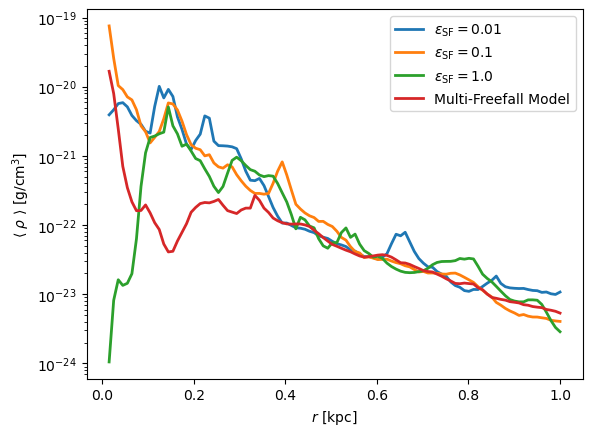

In [54]:
for sim in list_of_sim:
    
    r_1d, density_1d = sim.calc_radial_profile(sim.density, nbins=100)

    plt.plot(r_1d / const.kpc, density_1d, lw=2, label=sim.sim_latex)
    
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.legend()

plt.yscale('log')

# save_fig('density-compare')


Saved figure as 'v-turb-compare-092720231130.png'


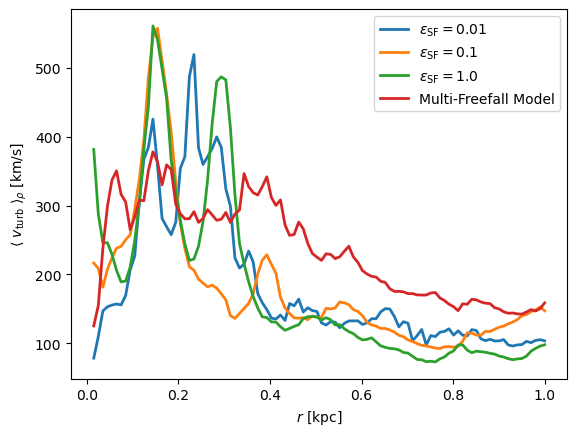

In [53]:
for sim in list_of_sim:
    
    r_1d, turb_energy_1d = sim.calc_radial_profile(sim.turb_energy, weight=sim.density, nbins=100)
    v_turb_1d = np.sqrt(2 * turb_energy_1d)

    plt.plot(r_1d / const.kpc, v_turb_1d / (const.km), lw=2, label=sim.sim_latex)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~v_{\rm turb}~\rangle_\rho$ [km/s]')

plt.legend()

# save_fig('v-turb-compare')


Saved figure as 'temp-compare-092720231130.png'


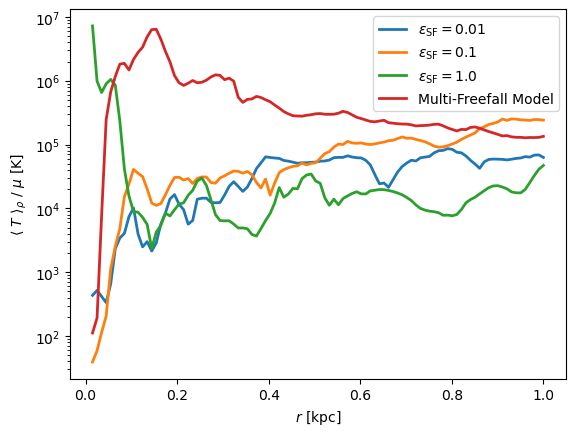

In [52]:
for sim in list_of_sim:
    
    r_1d, temperature_1d = sim.calc_radial_profile(sim.temperature, weight=sim.density, nbins=100)

    plt.plot(r_1d / const.kpc, temperature_1d, lw=2, label=sim.sim_latex)
    
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho~/~\mu$ [K]')

plt.legend()

plt.yscale('log')

# save_fig('temp-compare')


Saved figure as 'SFR-compare-v3-101120230930.png'


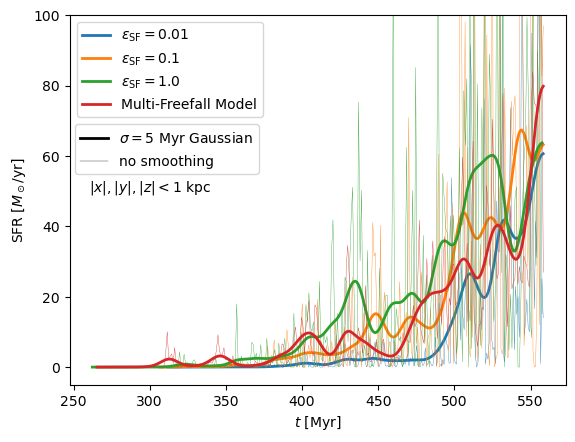

In [50]:
nbins = 300
filter_sigma = 5 * const.Myr

for i, sim in enumerate(list_of_sim):

    counts, bins = np.histogram(sim.time_starbirth, bins=nbins, weights=sim.mass_star)

    star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
    star_mass_1d = counts
    SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

    filter_sigma_idx = filter_sigma / np.diff(star_birth_time_1d)[0]
    SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)
    
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=0.25, alpha=1., color='C%d' % i)
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, label=sim.sim_latex, color='C%d' % i)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

legend1 = plt.legend()
custom_lines = [Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=0.25)]
legend2 = plt.legend(custom_lines, [r'$\sigma=%d~{\rm Myr}$ Gaussian' % (filter_sigma / const.Myr), 'no smoothing'], loc=[0.01, 0.57])
plt.gca().add_artist(legend1)

plt.ylim(-5, 100)

plt.annotate(r'$|x|, |y|, |z| < 1~{\rm kpc}$', (260, 50))

save_fig('SFR-compare-v3')


Text(260, 130, '$|x|, |y|, |z| < 1~{\\rm kpc}$')

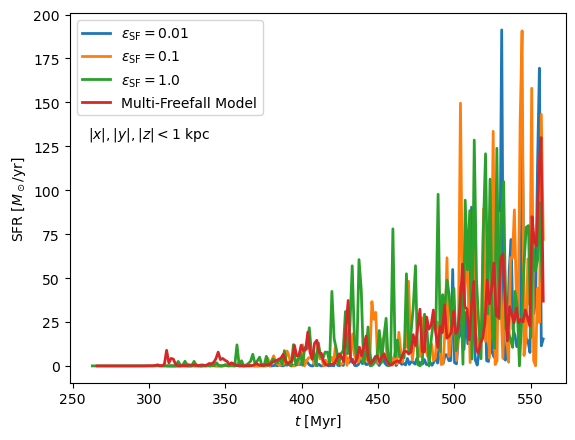

In [52]:
nbins = 200
filter_sigma = 10 * const.Myr

for i, sim in enumerate(list_of_sim):

    counts, bins = np.histogram(sim.time_starbirth, bins=nbins, weights=sim.mass_star)

    star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
    star_mass_1d = counts
    SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

    filter_sigma_idx = filter_sigma / np.diff(star_birth_time_1d)[0]
    SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)
    
    plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=2, alpha=1., color='C%d' % i, label=sim.sim_latex)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

plt.legend()

#plt.ylim(-5, 70)

plt.annotate(r'$|x|, |y|, |z| < 1~{\rm kpc}$', (260, 130))

#save_fig('SFR-compare-v2')


Text(290, 140, '$|x|, |y|, |z| < 1~{\\rm kpc}$')

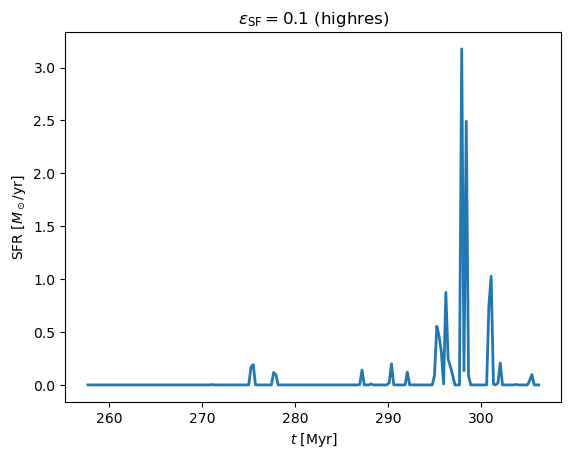

In [48]:
nbins = 200
filter_sigma = 10 * const.Myr

sim = sim

counts, bins = np.histogram(sim.time_starbirth, bins=nbins, weights=sim.mass_star)

star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
star_mass_1d = counts
SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

filter_sigma_idx = filter_sigma / np.diff(star_birth_time_1d)[0]
SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)

plt.plot(star_birth_time_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=2, alpha=1., label=sim.sim_latex)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

#plt.xlim(280, 570)
#plt.ylim(-10, 150)

plt.title(sim.sim_latex)

plt.annotate(r'$|x|, |y|, |z| < 1~{\rm kpc}$', (290, 140))

# sim.save_fig('SFR-compare')


NameError: name 'list_of_sim' is not defined

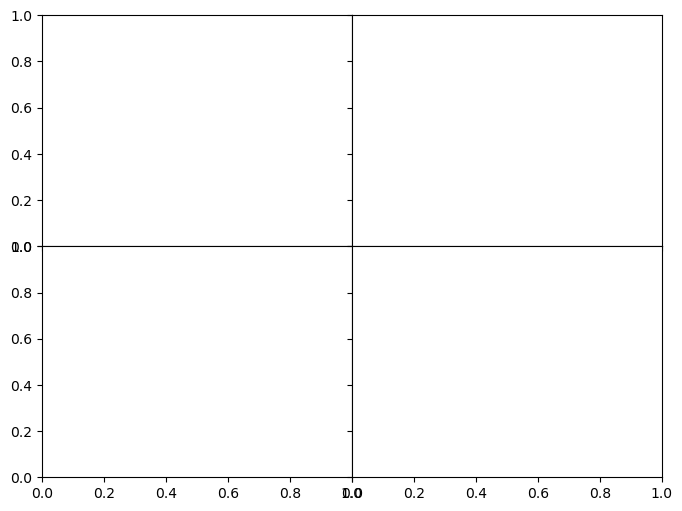

In [110]:
nbins = 200
filter_sigma = 10 * const.Myr

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 6))

plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

for i, sim in enumerate(list_of_sim):

    ax = axs.flatten()[i]
    
    counts, bins = np.histogram(sim.time_starbirth, bins=nbins, weights=sim.mass_star)

    star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
    star_mass_1d = counts
    SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

    filter_sigma_idx = filter_sigma / np.diff(star_birth_time_1d)[0]
    SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)
    
    ax.plot(star_birth_time_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=0.5, alpha=1., color='C%d' % i)
    ax.plot(star_birth_time_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, alpha=1., color='C%d' % i, label=sim.sim_latex)
    
    if i in [0, 2]:
        ax.set_ylabel(r"SFR [$M_\odot / {\rm yr}$]")
    if i in [2, 3]:
        ax.set_xlabel(r"$t$ [Myr]")
        
    ax.set_xlim(280, 570)
    ax.set_ylim(-10, 130)
    
    #ax.legend(loc=2)
    
#plt.suptitle(r'$|x|, |y|, |z| < 1~{\rm kpc}$', y=0.92)

custom_lines1 = [Line2D([0], [0], color='C0', lw=2), Line2D([0], [0], color='C1', lw=2), Line2D([0], [0], color='C2', lw=2), Line2D([0], [0], color='C3', lw=2)]
legend1 = axs[0, 0].legend(custom_lines1, [r'$\varepsilon_{\rm SF} = 0.01$', r'$\varepsilon_{\rm SF} = 0.1$', r'$\varepsilon_{\rm SF} = 1.0$', r'Multi-freefall Model'])

custom_lines2 = [Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=0.5)]
legend2 = axs[0, 0].legend(custom_lines2, [r'$\sigma=%d~{\rm Myr}$ Gaussian' % (filter_sigma / const.Myr), 'no smoothing'], loc=[0.03, 0.32])

axs[0, 0].add_artist(legend1)

axs[0, 0].annotate(r'$|x|, |y|, |z| < 1~{\rm kpc}$', (290, 23))

# save_fig('SFR-compare-v5')
    

In [160]:
1 / (1 / (2**14)**3 * sim.Omega_b0 / sim.Omega_m0 * sim.mass_unit / const.M_sol)


0.00022733305549378524